# Implementing Fourier transform as a Neural Network
> A walk through on understanding Fourier transform using NN.

- toc: true 

# What is a Discrete Fourier transform (DFT)

I will start by assuming DFT is a black box. Our friend Tom has been kind enough to supply us with a dataset composed of inputs signals and corresponding output signals obtained from this black box. We know little bit about neural networks (NNs). So, lets use to model this black box.

Essentially, we will split the dataset given by Tommy into a train (80% samples) and a validation set (20% samples). Subsequently, using the training set we will train a NN to learn a mapping from input to output. The validation set will be used only for testing to verify if the mapping is generalizing to new data not seen by the NN during training.

(The idea presented here is something I asked [Brandon Wu](https://github.com/brandonspark) (the amazing!) to try on one day of his internship. Both of us jumped from our seats when we saw the matrix plot shown at the end).

# Making the dataset

Let's get the data from Tom.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

dim_signal = 256
dataset_samples = 5000
# 256x1 dimension white noise vectors 
data = [np.random.randn(1, dim_signal).T for _ in range(dataset_samples)] 

# real(DFT(data))
cosData = [np.real(fft(x,axis=0)) for x in data]
cosData = np.array(cosData)
cosData = cosData.reshape(cosData.shape[0], cosData.shape[1])

# imaginary(DFT(data))
sinData = [np.imag(fft(x,axis=0)) for x in data]
sinData = np.array(sinData)
sinData = sinData.reshape(sinData.shape[0], sinData.shape[1])

```
Let's see an example from our dataset.
```

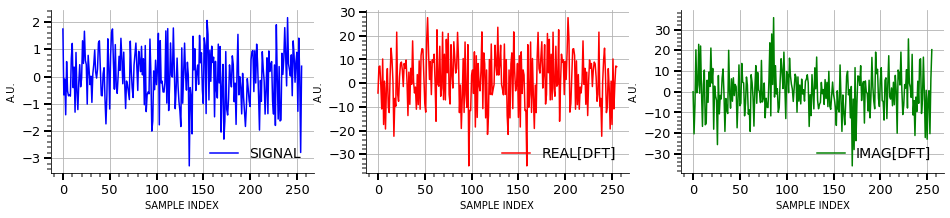

In [2]:
fig = plt.subplots(figsize=(16,3))
ax = plt.subplot(1,3,1)
plt.plot(data[0],color='blue',label='SIGNAL')
ax.set_xlabel('SAMPLE INDEX')
ax.set_ylabel('A.U.')
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)  
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='gray')
ax.legend(loc='lower right',frameon=False,fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.figure.savefig('signal.pdf', bbox_inches='tight')

ax = plt.subplot(1,3,2)
plt.plot(cosData[0],color='red',label='REAL[DFT]')
ax.set_xlabel('SAMPLE INDEX')
ax.set_ylabel('A.U.')
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)  
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='gray')
ax.legend(loc='lower right',frameon=False,fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.figure.savefig('signal_DFT_real.pdf', bbox_inches='tight')

ax = plt.subplot(1,3,3)
plt.plot(sinData[0],color='green',label='IMAG[DFT]')
ax.set_xlabel('SAMPLE INDEX')
ax.set_ylabel('A.U.')
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)  
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='gray')
ax.legend(loc='lower right',frameon=False,fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.figure.savefig('signal_DFT_imag.pdf', bbox_inches='tight')

plt.show()

# Our Neural Network

The output of a DFT is a complex signal. We will model this as a sum of a real and an imaginary part. This way our NN will be dealing only with real values.

<img src="my_images/DFT_network_fit.jpeg" alt="drawing" width="400"/>

Step 1: build the NN structure

In [3]:
# import pytorch packages
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.autograd import Variable
import time

class fourier(nn.Module):
    def __init__(self):
        super(fourier, self).__init__()
        self.sinLayer = nn.Linear(256, 256)
        self.cosLayer = nn.Linear(256, 256)
    def forward(self, x):
        y1 = self.sinLayer(x)
        y2 = self.cosLayer(x)
        return y1, y2

class FourierDataset(Dataset):
    def __init__(self, data, output1, output2):
        indx = int(0.8 * len(data))
        first = [(data[i], output1[i], output2[i]) for i in range(len(data)) if i < indx]
        second = [(data[i], output1[i], output2[i]) for i in range(len(data)) if i >= indx]
        self.data = first
        self.validation = second
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

def nLoss(lossFun, one, two):
    print(1)
    loss = 0
    for i in range(len(one)):
        print(2)
        loss += lossFun(one[i], two[i]).numpy()
        print(3)
    return loss


Step 2: Initialize the NN training parameters

In [69]:
num_epochs = 800
batch_size = 128
learning_rate = 1e-4

Fourier = fourier() 
dataset = FourierDataset(data, sinData, cosData)
dataloader = DataLoader(dataset.data, batch_size=batch_size, shuffle=True)

In [70]:
optimizer = torch.optim.Adam(
    Fourier.parameters(), lr=learning_rate, weight_decay=1e-5)

criterion = nn.MSELoss()
losses = []
vlosses = []
regs = []

# make the validation data tensor
validData = []
validSin = []
validCos = []
for dataIns in dataset.validation:
    validData.append(dataIns[0])
    validSin.append(dataIns[1])
    validCos.append(dataIns[2])

validSin = torch.from_numpy(np.array(validSin))
validCos = torch.from_numpy(np.array(validCos))
validData = torch.from_numpy(np.array(validData))
validData = validData.reshape(validData.shape[0],1,256)

Step 3: Train the NN using forward pass of training data and backward pass of trianing error updating the NN weights. This process is iterated num_epochs times.

In [71]:
# we will monitor a sample (indx) from the validation set
examp_cos_output = []
examp_sin_output = []
indx = 10
weightSinLayer = []

# train the NN for num_epochs
start_time = time.time()
for epoch in range(num_epochs):
    for dataIns in dataloader:
        img, sinCorrect, cosCorrect = dataIns
        sinCorrect = sinCorrect.reshape(sinCorrect.shape[0], sinCorrect.shape[1])
        cosCorrect = cosCorrect.reshape(cosCorrect.shape[0], cosCorrect.shape[1])
        img = img.view(img.size(0), -1)
        img = img.reshape(img.shape[0],1,256)
        # ===================forward=====================
        sinOutput, cosOutput = Fourier(img.float())
        loss1 = criterion(sinOutput.reshape(sinOutput.shape[0], sinOutput.shape[2]), sinCorrect.float())
        loss2 = criterion(cosOutput.reshape(cosOutput.shape[0], cosOutput.shape[2]), cosCorrect.float())
        loss = loss1 + loss2
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # ===================forward=====================
    sinOutput2, cosOutput2 = Fourier(validData.float())
    loss1 = criterion(sinOutput2.reshape(sinOutput2.shape[0], sinOutput2.shape[2]), validSin.float())
    loss2 = criterion(cosOutput2.reshape(cosOutput2.shape[0], cosOutput2.shape[2]), validCos.float())
    vloss = loss1 + loss2
    
    # ===================store loss==================
    losses.append(loss.data.numpy())
    vlosses.append(vloss.data.numpy())
    if epoch % 50 == 0:
        print('epoch [{}/{}], loss:{:.4f}, validation_loss:{:.4f}, time_elapsed:{:.4f}'
              .format(epoch + 1, num_epochs, loss.data, vlosses[-1], time.time() - start_time))
    if vlosses[-1] <= 0.0001:
        print(vlosses[-1])
        break
    # ===================store and example signal==========
    examp_cos_output.append(cosOutput2.detach().numpy()[indx])
    examp_sin_output.append(sinOutput2.detach().numpy()[indx])
    
    # =================== store the sine layer 256x256 weight matix ==========
    for i, param in enumerate(Fourier.parameters()):
        if i == 0:
            a = param.detach().numpy().copy()
            weightSinLayer.append(a)


epoch [1/800], loss:258.2382, validation_loss:255.5916, time_elapsed:0.1411
epoch [51/800], loss:196.6595, validation_loss:200.4876, time_elapsed:7.2933
epoch [101/800], loss:147.5006, validation_loss:154.0908, time_elapsed:14.3655
epoch [151/800], loss:110.7806, validation_loss:114.9219, time_elapsed:20.8714
epoch [201/800], loss:76.2455, validation_loss:82.2963, time_elapsed:27.5049
epoch [251/800], loss:51.3001, validation_loss:55.8251, time_elapsed:36.9585
epoch [301/800], loss:32.0512, validation_loss:35.1757, time_elapsed:46.5460
epoch [351/800], loss:17.3773, validation_loss:19.9666, time_elapsed:56.1011
epoch [401/800], loss:8.4049, validation_loss:9.6959, time_elapsed:65.5383
epoch [451/800], loss:2.8125, validation_loss:3.6714, time_elapsed:75.0106
epoch [501/800], loss:0.6671, validation_loss:0.9133, time_elapsed:84.1194
epoch [551/800], loss:0.0897, validation_loss:0.1225, time_elapsed:91.5053
epoch [601/800], loss:0.0154, validation_loss:0.0191, time_elapsed:97.9016
epoch 

```
Let's visulaize the train and validation losses as a function of epoch counts. We will like this to decrease monotonically, and it indeed does so. This implies the NN is learning the mapping, and also generalizing it to the validations set.
```

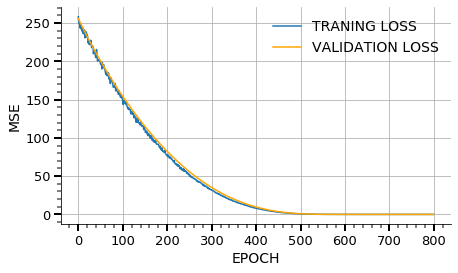

In [72]:
FS = 14
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(losses, label = 'TRANING LOSS')
ax.plot(vlosses,color='orange',label='VALIDATION LOSS')
ax.set_ylabel('MSE',fontsize=FS)
ax.set_xlabel('EPOCH',fontsize=FS)
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)  
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='gray')
ax.legend(loc='upper right',frameon=False,fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()


Step 4: Lets also see an example signal to visualize the learnt fit on a signal sample from validation data.

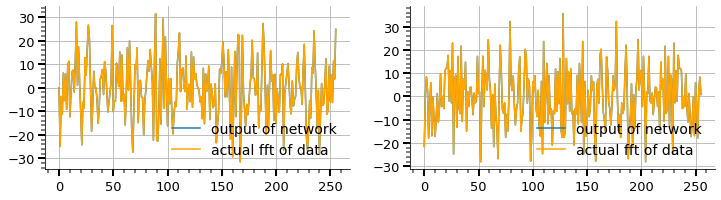

In [73]:
fig = plt.subplots(figsize=(12, 3))

indx = 10
ax = plt.subplot(1,2,1)
thisOutput = sinOutput.detach().numpy()
thisCorrect = sinCorrect.detach().numpy()
ax.plot(thisOutput[indx].T, label='output of network')
ax.plot(thisCorrect[indx].T, color='orange', label='actual fft of data')
ax.legend()
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)  
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='gray')
ax.legend(loc='lower right',frameon=False,fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

ax = plt.subplot(1,2,2)
thisOutput = cosOutput.detach().numpy()
thisCorrect = cosCorrect.detach().numpy()
ax.plot(thisOutput[indx].T, label='output of network')
ax.plot(thisCorrect[indx].T, color='orange', label='actual fft of data')
ax.legend()
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)  
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='gray')
ax.legend(loc='lower right',frameon=False,fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()


Lets also visualize how the NN approximates the mapping over epochs. We will take a signal from the validation set and plot it estimated DFT using NN over the epochs.Below is the gif.

![](./my_images/DFT_valid_examp.gif)

Below is the code snippet I used to generate the video to make the above gif.

Lets now understand the weight learnt by the NN. As this NN has no nonlinearity hence, visualizing the weights can give us a good understanding of what the NN is doing here.

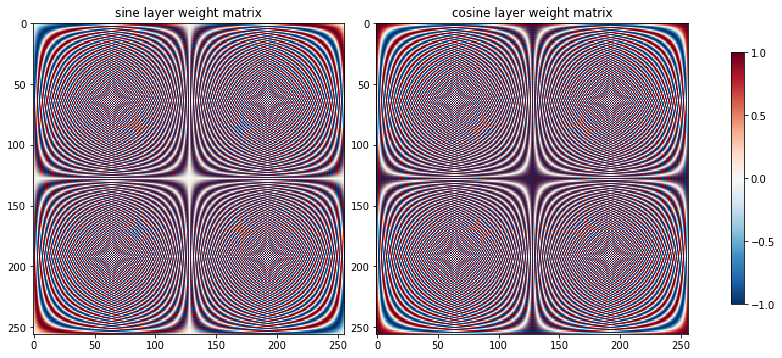

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7))

for i, param in enumerate(Fourier.parameters()):
    if i == 0:
        axes[0].imshow(param.detach().numpy(),cmap='RdBu_r',vmin=-1, vmax=1)
        axes[0].set_title('sine layer weight matrix')
    elif i == 2:
        pos = axes[1].imshow(param.detach().numpy(),cmap='RdBu_r',vmin=-1, vmax=1)
        axes[1].set_title('cosine layer weight matrix')
fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.015, 0.5]) #(xloc,yloc,width,height)
fig.colorbar(pos, cax=cbar_ax,ticks=[-1,-0.5,0,0.5,1])
plt.show()


A epoch-wise evolution of the sine layer weight matrix is shown below.
![](./my_images/DFT_matrix_animation.gif)


In [ ]:
Lets see few columns of the sine and cosine matrix

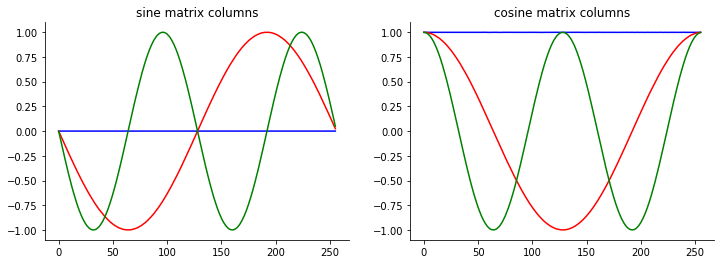

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, param in enumerate(Fourier.parameters()):
    if i == 0:
        axes[0].plot(param.detach().numpy()[0],color='b')
        axes[0].plot(param.detach().numpy()[1],color='r')
        axes[0].plot(param.detach().numpy()[2],color='g')
        axes[0].set_title('sine matrix columns')
        axes[0].spines['right'].set_visible(False)
        axes[0].spines['top'].set_visible(False)  
    elif i == 2:
        axes[1].plot(param.detach().numpy()[0],color='b')
        axes[1].plot(param.detach().numpy()[1],color='r')
        axes[1].plot(param.detach().numpy()[2],color='g')
        axes[1].set_title('cosine matrix columns')
        axes[1].spines['right'].set_visible(False)
        axes[1].spines['top'].set_visible(False)  
plt.show()

# That's it

Each row in the above matrices are approximating the basis vectors corresponding to sine and cosine waves in traditional DFT matrix. Thus, the NN, learning a linear transformation here, converges to the unique solution, that is, the DFT matrix here. So we learnt that,
* the DFT black box is composed of these matrices
* the matrices are composed of sine and cosine signals
* the MSE between traditional DFT and NN implementation decreases over epochs

# Appendices

In [ ]:
# code for spectrum fit animation
trueSpectrum = 10*np.log10(validCos.detach().numpy()[indx]**2+validSin.detach().numpy()[indx]**2)

from matplotlib import animation, rc
rc('animation',html='jshtml')

fig = plt.figure(figsize=(7,4))
ax = plt.subplot(1,1,1)
plt.plot(np.arange(0,256,1),trueSpectrum,color='b',label='TRUE')
plt.xlabel('DFT BIN',fontsize=14)
plt.ylabel('PSD [in dB]',fontsize=14)
line, = plt.plot(np.arange(0,256,1),np.zeros((256,)),color='r',label='ESTIMATED')
plt.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)  
ax.legend(loc='lower right',frameon=False,fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.close()

def animate(i):
    outputSpectrum = 10*np.log10(examp_cos_output[i][0]**2+examp_sin_output[i][0]**2)
    line.set_ydata(outputSpectrum)
    return line,
anim = animation.FuncAnimation(fig,animate,np.arange(0,400), interval=20)
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
anim.save('anim_1.mp4', writer=writer)


# code for matrix video
import matplotlib.animation as animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(5,5) )

im = plt.imshow(np.zeros((256,256)), aspect='auto', vmin=-1, vmax=1,cmap='RdBu_r')
plt.title('sine layer wieght matrix over epochs')
def animate_func(i):
    im.set_array(weightSinLayer[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = np.arange(0,799),
                               interval = 20, # in ms
                               )
anim.save('anim_2.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

print('Done!')